# 时间序列

## 原始代码

In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Shape of data arrays: (143, 7) (143,)


[(100, 7), (100,), (43, 7), (43,)]

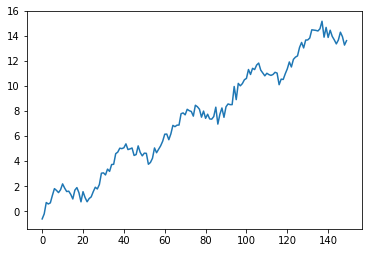

In [51]:
# 获得数据
season = pd.Series([0.1 * i + np.sin(0.2 * i) + 0.3 * np.random.randn(1).item() for i in range(150)])
plt.plot(season);

# 构建训练集合和测试集合
def makeXy(ts, nb_timesteps):
    X, y = [], []
    for i in range(nb_timesteps, ts.shape[0]):
        X.append(list(ts.loc[i-nb_timesteps:i-1]))
        y.append(ts.loc[i])
    X, y = np.array(X), np.array(y)
    return X, y

nlags = 7
X, y = makeXy(season, nlags)
print('Shape of data arrays:', X.shape, y.shape)

# 划分训练集和测试集，70% 作为训练集
train_size = int(len(X) * 0.7)
test_size = len(X) - train_size
X_train = X[:train_size]
y_train = y[:train_size]
X_test = X[train_size:]
y_test = y[train_size:]

[d.shape for d in [X_train, y_train, X_test, y_test]]

/home/yons/anaconda3/envs/torch/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/home/yons/anaconda3/envs/torch/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':
/home/yons/anaconda3/envs/torch/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.


Epoch: 100, Loss: 1.15504
Epoch: 200, Loss: 0.67360
Epoch: 300, Loss: 0.60558
Epoch: 400, Loss: 0.55457
Epoch: 500, Loss: 0.51201
Epoch: 600, Loss: 0.47683
Epoch: 700, Loss: 0.44749
Epoch: 800, Loss: 0.42188
Epoch: 900, Loss: 0.39856
Epoch: 1000, Loss: 0.37714


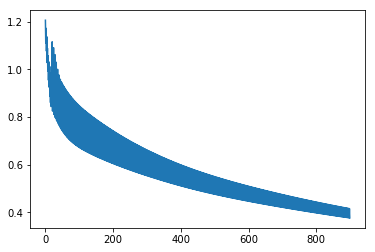

In [57]:
import torch
from torch import nn

X_train = X_train.reshape(-1, 1, nlags)
y_train = y_train.reshape(-1, 1, 1)
X_test = X_test.reshape(-1, 1, nlags)

X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()

X_train.shape, y_train.shape, X_test.shape

# 定义模型
class lstm_reg(nn.Module):
    def __init__(self, input_size, hidden_size, output_size=1, num_layers=2):
        super(lstm_reg, self).__init__()
        
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers) # rnn
        self.reg = nn.Linear(hidden_size, output_size) # 回归
        
    def forward(self, x):
        x, _ = self.rnn(x) # (seq, batch, hidden)
        s, b, h = x.shape
        x = x.view(s * b, h) # 转换成线性层的输入格式
        x = self.reg(x)
        x = x.view(s, b, -1) # (seq, batch, hidden)
        return x

net = lstm_reg(nlags, 20, num_layers=1)

criterion = nn.MSELoss()
optimizer = torch.optim.SGD(net.parameters(), lr=1e-2)

# 开始训练
epochs = 1000
costs = []
for epoch in range(epochs):
    
    # 前向传播和计算损失
    out = net(X_train)
    loss = criterion(out, y_train)
    costs.append(loss.item())
    
    # 反向传播和参数更新
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 100 == 0: # 每 100 次输出结果
        print('Epoch: {}, Loss: {:.5f}'.format(epoch + 1, loss.data.item()))
        
plt.plot(costs[100:])

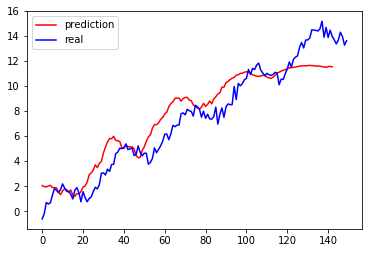

In [59]:
# 模型评估
net = net.eval() # 转换成测试模式
ypred = net(torch.tensor(X.reshape(-1, 1, nlags)).float()) # 测试集的预测结果

# 改变输出的格式
ypred = ypred.view(-1).data.numpy()

# 画出实际结果和预测的结果
plt.plot(ypred, 'r', label='prediction')
plt.plot(season, 'b', label='real')
plt.legend(loc='best');

## 加入时间项目

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [41]:
X.shape, X

((143, 8), array([[4.80685563e-01, 1.08183925e-02, 8.59847154e-01, ...,
         1.35069344e+00, 1.34586316e+00, 7.00000000e+00],
        [1.08183925e-02, 8.59847154e-01, 3.31515565e-01, ...,
         1.34586316e+00, 2.06126787e+00, 8.00000000e+00],
        [8.59847154e-01, 3.31515565e-01, 1.39422315e+00, ...,
         2.06126787e+00, 2.00231436e+00, 9.00000000e+00],
        ...,
        [1.41158219e+01, 1.44301247e+01, 1.39335655e+01, ...,
         1.36190161e+01, 1.40493735e+01, 1.47000000e+02],
        [1.44301247e+01, 1.39335655e+01, 1.42458214e+01, ...,
         1.40493735e+01, 1.43028587e+01, 1.48000000e+02],
        [1.39335655e+01, 1.42458214e+01, 1.35838452e+01, ...,
         1.43028587e+01, 1.42791225e+01, 1.49000000e+02]]))

In [32]:
t = ['a', 'b', 'c', 'd', 'e', 'f']

# [[a, b, 1], [b, c, 2], [c, d, 3], ...]

Shape of data arrays: (143, 8) (143,)


[(100, 8), (100,), (43, 8), (43,)]

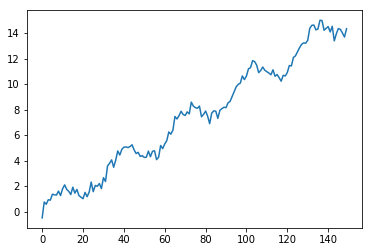

In [42]:
# 获得数据
season = pd.Series([0.1 * i + np.sin(0.2 * i) + 0.3 * np.random.randn(1).item() for i in range(150)])
plt.plot(season);

# 构建训练集合和测试集合
def makeXy(ts, nb_timesteps):
    X, y = [], []
    for i in range(nb_timesteps, ts.shape[0]):
        tmp = list(ts.loc[i-nb_timesteps:i-1])
        tmp.append(i)
        X.append(tmp)
        y.append(ts.loc[i])
    X, y = np.array(X), np.array(y)
    return X, y

nlags = 7
X, y = makeXy(season, nlags)
print('Shape of data arrays:', X.shape, y.shape)

# 划分训练集和测试集，70% 作为训练集
train_size = int(len(X) * 0.7)
test_size = len(X) - train_size
X_train = X[:train_size]
y_train = y[:train_size]
X_test = X[train_size:]
y_test = y[train_size:]

[d.shape for d in [X_train, y_train, X_test, y_test]]

In [44]:
import torch
from torch import nn

X_train = X_train.reshape(-1, 1, nlags + 1)
y_train = y_train.reshape(-1, 1, 1)
X_test = X_test.reshape(-1, 1, nlags + 1)

X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()

X_train.shape, y_train.shape, X_test.shape

(torch.Size([100, 1, 8]), torch.Size([100, 1, 1]), torch.Size([43, 1, 8]))

In [45]:
# 定义模型
class lstm_reg(nn.Module):
    def __init__(self, input_size, hidden_size, output_size=1, num_layers=2):
        super(lstm_reg, self).__init__()
        
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers) # rnn
        self.reg = nn.Linear(hidden_size, output_size) # 回归
        
    def forward(self, x):
        x, _ = self.rnn(x) # (seq, batch, hidden)
        s, b, h = x.shape
        x = x.view(s * b, h) # 转换成线性层的输入格式
        x = self.reg(x)
        x = x.view(s, b, -1) # (seq, batch, hidden)
        return x

net = lstm_reg(nlags+1, 40)

criterion = nn.MSELoss()
optimizer = torch.optim.SGD(net.parameters(), lr=1e-2)

Epoch: 100, Loss: 7.06444
Epoch: 200, Loss: 10.44129
Epoch: 300, Loss: 8.50783
Epoch: 400, Loss: 7.40931
Epoch: 500, Loss: 5.32575
Epoch: 600, Loss: 2.41650
Epoch: 700, Loss: 2.08013
Epoch: 800, Loss: 1.85287
Epoch: 900, Loss: 1.67412
Epoch: 1000, Loss: 1.52828


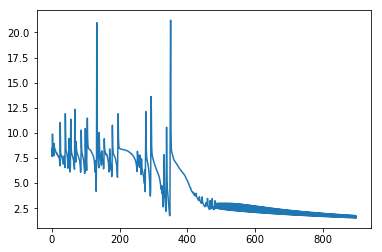

In [46]:
# 开始训练
epochs = 1000
costs = []
for epoch in range(epochs):
    
    # 前向传播和计算损失
    out = net(X_train)
    loss = criterion(out, y_train)
    costs.append(loss.item())
    
    # 反向传播和参数更新
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 100 == 0: # 每 100 次输出结果
        print('Epoch: {}, Loss: {:.5f}'.format(epoch + 1, loss.data.item()))
        
plt.plot(costs[100:])
plt.show()

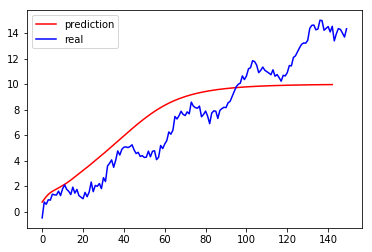

In [49]:
# 模型评估
net = net.eval() # 转换成测试模式
ypred = net(torch.tensor(X.reshape(-1, 1, nlags+1)).float()) # 测试集的预测结果

# 改变输出的格式
ypred = ypred.view(-1).data.numpy()

# 画出实际结果和预测的结果
plt.plot(ypred, 'r', label='prediction')
plt.plot(season, 'b', label='real')
plt.legend(loc='best')
plt.show()